In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
 # Conexión a BD
# ==============================================================================
import pyodbc

In [3]:
# Configuración de BD y conexión
# ==============================================================================
direccion_servidor = '192.168.1.32,55078'
nombre_bd = 'BDVirunet'
nombre_usuario = 'sa'
password = '123456'

try:
    conexion = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + 
                              direccion_servidor+';DATABASE='+nombre_bd+';UID='+nombre_usuario+';PWD=' + password)
    print("Conexión exitosa")
    
except Exception as e:
    print("Ocurrió un error al conectar a SQL Server: ", e)

Conexión exitosa


In [4]:
dFechaInicio = '2020-01-01'
dFechaFin = '2020-12-31'

In [5]:
try:
    with conexion.cursor() as cursor:
            consulta = "exec STP_OBTENER_TOTALIZADO_PLAGAS ?,?,?,?"
            cursor.execute(consulta, (dFechaInicio, dFechaFin, 1,0))

            rows = cursor.fetchall()
            
            cols = []
            
            for i,_ in enumerate(cursor.description):
                cols.append(cursor.description[i][0])

            pd.DataFrame(np.array(rows), columns = cols)
            
            df = pd.DataFrame(columns =['Evaluador','Fecha','Fundo','Filtrado','Turno','Lote','Grupo_Plaga','Plaga','Caracteristica','Suma','Grado','Promedio','Porcentaje'] )
            for i in range(len(rows)):
                df.loc[i] = list(rows[i])
except Exception as e: 
    print(e)

In [6]:
dfPlaga =  df

In [7]:
## Revisando la mayor cantidad de evaluaciones por filtrado

In [8]:
for filtrado in df["Filtrado"].unique():
    print("Filtrado: " + filtrado)
    nCantidadFiltrado = df[df["Filtrado"] == filtrado].shape[0]
    print("Cantidad: " + str(nCantidadFiltrado))
filtradosEleg = ["17","20","10N"]
dfFilEleg = df[df["Filtrado"].isin(filtradosEleg)]   

Filtrado: 10
Cantidad: 202
Filtrado: 10N
Cantidad: 1033
Filtrado: 11N
Cantidad: 202
Filtrado: 17
Cantidad: 4857
Filtrado: 20
Cantidad: 4153
Filtrado: 28
Cantidad: 569
Filtrado: 29
Cantidad: 300
Filtrado: 9N
Cantidad: 210


In [9]:
filtradosEleg = ["17","20", "10N"]
dfFilEleg = dfPlaga[dfPlaga["Filtrado"].isin(filtradosEleg)]

In [10]:
dfFilEleg.head()

,Evaluador,Fecha,Fundo,Filtrado,Turno,Lote,Grupo_Plaga,Plaga,Caracteristica,Suma,Grado,Promedio,Porcentaje
202,fchavez,2020-01-03,VIRU - PALTO,10N,F10N,1011,BROTES,ARGYROTAENIA SPHALEROPA,N° BROTES INFESTADOS,1,--,--,4
203,fchavez,2020-01-03,VIRU - PALTO,10N,F10N,1011,HOJAS,"OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI",N° HOJAS INFESTADAS,73,--,--,73
204,fchavez,2020-01-03,VIRU - PALTO,10N,F10N,1011,HOJAS,SABULODES AEGROTATA,N° HOJAS INFESTADAS,1,--,--,1
205,fchavez,2020-01-03,VIRU - PALTO,10N,F10N,1011,HOJAS,BEMISIA TABACI,N° HOJAS INFESTADAS,3,--,--,3
206,fchavez,2020-01-03,VIRU - PALTO,10N,F10N,1012,HOJAS,"OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI",N° HOJAS INFESTADAS,73,--,--,73


In [11]:
dfFilEleg['Semana'] = pd.to_datetime(dfFilEleg['Fecha'], format='%Y-%m-%d').dt.weekofyear

In [12]:
dfFilEleg.head()

,Evaluador,Fecha,Fundo,Filtrado,Turno,Lote,Grupo_Plaga,Plaga,Caracteristica,Suma,Grado,Promedio,Porcentaje,Semana
202,fchavez,2020-01-03,VIRU - PALTO,10N,F10N,1011,BROTES,ARGYROTAENIA SPHALEROPA,N° BROTES INFESTADOS,1,--,--,4,1
203,fchavez,2020-01-03,VIRU - PALTO,10N,F10N,1011,HOJAS,"OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI",N° HOJAS INFESTADAS,73,--,--,73,1
204,fchavez,2020-01-03,VIRU - PALTO,10N,F10N,1011,HOJAS,SABULODES AEGROTATA,N° HOJAS INFESTADAS,1,--,--,1,1
205,fchavez,2020-01-03,VIRU - PALTO,10N,F10N,1011,HOJAS,BEMISIA TABACI,N° HOJAS INFESTADAS,3,--,--,3,1
206,fchavez,2020-01-03,VIRU - PALTO,10N,F10N,1012,HOJAS,"OLYGONICHUS PUNICAE, OLIGONYCHUS YOTHERSI",N° HOJAS INFESTADAS,73,--,--,73,1


In [13]:
data_weather = pd.ExcelFile('D:/Proyectos GitHub/Python/Datos/Datos Climaticos Viru Palto.xlsx')
df_weather = data_weather.parse('TABLA')  
data_weather.close()

In [14]:
df_weather = df_weather[df_weather['Año'] == 2020]
df_weather = df_weather[(df_weather['Fecha'] >= dFechaInicio) & (df_weather['Fecha'] <= dFechaFin)]
df_weather.reset_index(drop = True, inplace = True)

In [15]:
df_weather = df_weather[['Fecha','ET(mm).','Tº MIN/DIA (°C)','Tº MAX/DIA (°C)','Rad. Solar Prom.','HUMEDAD PROM.', 'T° Prom/Día (°C)','Semana']]
df_weather = df_weather.rename(columns = {'ET(mm).' : 'ET', 
                                      'Tº MIN/DIA (°C)' : 'T_MIN',
                                     'Tº MAX/DIA (°C)': 'T_MAX',
                                     'Rad. Solar Prom.' : 'RS_PROM',
                                     'HUMEDAD PROM.': 'HM_PROM',
                                      'T° Prom/Día (°C)': 'TMP_PROM',
                                         'Semana': 'Semana'})

In [16]:
#dfFilEleg = dfFilEleg[dfFilEleg["Plaga"] == "DAGBERTUS MINENSIS, DAGBERTUS PERUANUS"]

------------------------------------------------------------
Lugar: Filtrado 17 - Turno F17 - Lote 1718
Plaga:  LEPIDOPTEROS (OTROS)
Caracteristica:  N° HOJAS INFESTADAS
------------------------------------------------------------
         Fecha     ET   TMP_PROM  RS_PROM  HM_PROM  Porcentaje
0   2020-02-17  4.400  23.135417    277.7     77.0           1
1   2020-03-07  3.700  24.062500    215.5     77.0           1
2   2020-04-04  4.100  22.191667    249.2     84.0           1
3   2020-05-30  3.000  19.958333    213.3     86.0           1
4   2020-10-02  1.700  17.241667    116.1     87.0           1
5   2020-10-06  3.600  17.141667    259.5     85.0           2
6   2020-10-22  3.700  17.772917    250.6     86.0           3
7   2020-11-05  1.400  15.854167     96.9     86.0           3
8   2020-11-17  3.326  18.308333    221.7     83.8           1
9   2020-12-11  3.600  17.458333    224.9     86.0           3
10  2020-12-18  2.800  15.604762    247.9     85.0           3


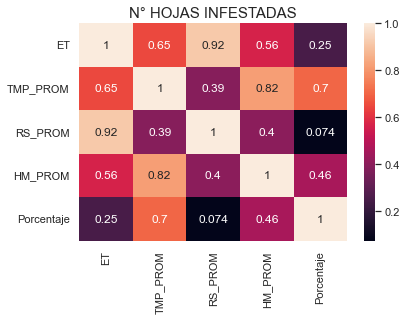

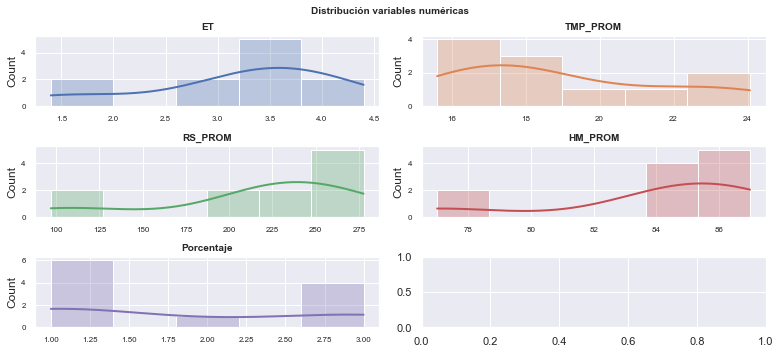

------------------------------------------------------------
Lugar: Filtrado 17 - Turno F17 - Lote 1713
Plaga:  LEPIDOPTEROS (OTROS)
Caracteristica:  N° HOJAS INFESTADAS
------------------------------------------------------------
         Fecha   ET   TMP_PROM  RS_PROM  HM_PROM  Porcentaje
0   2020-01-08  4.4  22.731250    262.3     74.0           2
1   2020-01-16  4.2  22.833333    249.8     85.0           1
2   2020-01-21  3.9  23.514583    232.3     81.0           1
3   2020-03-07  3.7  24.062500    215.5     77.0           1
4   2020-03-13  4.3  22.522917    275.3     78.0           1
5   2020-04-18  3.5  21.677083    218.2     87.0           2
6   2020-06-05  2.6  18.387500    177.6     86.0           1
7   2020-07-09  0.5  15.993750     36.5     90.0           3
8   2020-10-06  3.6  17.141667    259.5     85.0           3
9   2020-10-30  1.8  17.716667    126.0     83.0           3
10  2020-11-27  3.9  19.527083    255.0     83.0           1


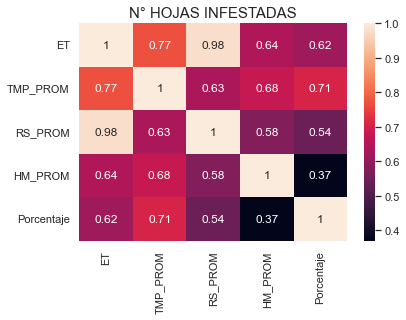

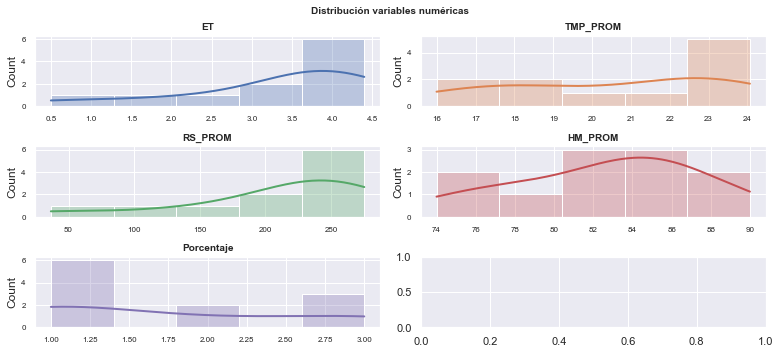

------------------------------------------------------------
Lugar: Filtrado 20 - Turno F20 - Lote 2022
Plaga:  SABULODES AEGROTATA
Caracteristica:  N° HOJAS INFESTADAS
------------------------------------------------------------
         Fecha    ET   TMP_PROM  RS_PROM  HM_PROM  Porcentaje
0   2020-01-17  3.80  22.116667    235.2     85.0           1
1   2020-02-05  4.20  22.829167    260.9     79.0           4
2   2020-02-14  0.10  17.600000     38.3     81.0           5
3   2020-06-26  1.90  17.122917    137.1     85.0           2
4   2020-09-04  2.00  15.631250    140.0     78.0           5
5   2020-09-11  0.90  15.160417     66.3     87.0           4
6   2020-09-14  2.30  16.331250    162.9     85.0           2
7   2020-09-24  2.90  16.587234    210.3     87.0           1
8   2020-10-13  2.10  17.018750    151.3     87.0           1
9   2020-11-07  3.76  17.070833    251.5     83.8           2
10  2020-12-10  2.50  17.175000    151.1     86.0           2


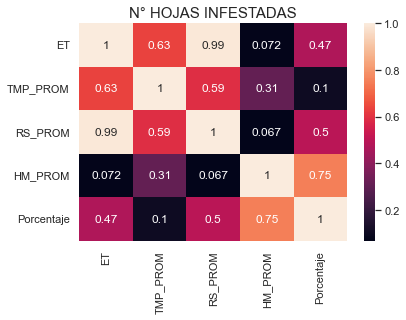

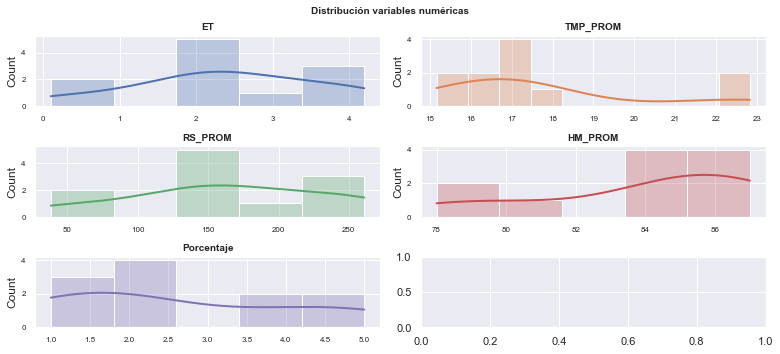

In [22]:
arrPlagas = []
dfFilter = dfFilEleg
arrFiltrados = dfFilEleg['Filtrado'].unique()
#dfFilter = df
dfCorrexLote = pd.DataFrame(columns=['Filtrado', 'Turno', 'Lote', 'Plaga','Caracteristica'])
iContador = 0
for filtrado in arrFiltrados:
    dfFiltrado = dfFilter[dfFilter['Filtrado'] == filtrado]
    arrTurno = dfFiltrado['Turno'].unique()
    for turno in arrTurno:
        dfTurno = dfFiltrado[dfFiltrado['Turno'] == turno]
        arrLote = dfTurno['Lote'].unique()
        for lote in arrLote:  
            dfLote = dfTurno[dfTurno['Lote'] == lote]
            arrPlagaxLote = dfLote['Plaga'].unique()
            for plaga in arrPlagaxLote:
                dfPlaga = dfLote[dfLote['Plaga'] == plaga]
                arrPlagaxCarac = dfPlaga['Caracteristica'].unique()
                for caracteristica in arrPlagaxCarac:
                    dfCarac = dfPlaga[dfPlaga['Caracteristica'] == caracteristica]
                    dfCarac = dfCarac.sort_values(by=['Fecha'])
         
                    dfCarac = dfCarac.groupby(['Fecha','Fundo','Filtrado','Turno','Plaga','Caracteristica'])['Porcentaje'].sum().reset_index()
                    
                    fl_df_weather = df_weather[df_weather['Fecha'].isin(dfCarac['Fecha'])]
                    fl_df_weather = fl_df_weather.sort_values(by=['Fecha'])
                    fl_df_weather.reset_index(drop = True, inplace = True)
                    fl_df_weather = fl_df_weather.rename(columns = {'Fecha' : 'FechaClima'})
                    df_union = fl_df_weather.join(dfCarac)
                 
                    # Filtrar el dataset por las variables que se usarán
                    #df_union = df_union[['Fecha','ET','TMP_PROM','T_MIN','T_MAX','RS_PROM','HM_PROM','Grado']]        
                    df_union = df_union[['Fecha','ET','TMP_PROM','RS_PROM','HM_PROM','Porcentaje']]   
                    
                    df_union[["Porcentaje"]] = df_union[["Porcentaje"]].apply(pd.to_numeric)
                    #print(df_union)
                
                    dfCorrelacion = df_union.corr().abs()
                    
                    dfCorrelacion_index = dfCorrelacion[dfCorrelacion['Porcentaje'] > 0.70]

                    if dfCorrelacion_index.shape[0] > 1 and df_union.shape[0] > 10:   
                        
                        dfCorrexLote = dfCorrexLote.append({'Filtrado': filtrado,'Turno': turno,'Lote' : lote, 'Plaga': plaga,'Caracteristica': caracteristica},ignore_index=True)
                        arrPlagas.append(plaga + ' ' + caracteristica)
                        #Creando Mapa de Calor
                        sns.set()
                        
                        print('------------------------------------------------------------')
                        print('Lugar: Filtrado {} - Turno {} - Lote {}'.format(filtrado,turno, lote))
                        print('Plaga: ', plaga)
                        print('Caracteristica: ', caracteristica)      
                        
                        print('------------------------------------------------------------')
                        
                        print(df_union)
                        
                        ax = sns.heatmap(dfCorrelacion, annot = True)
                        iContador = iContador + 1
                        plt.title('{}'.format(caracteristica), fontdict = { 'fontsize' : '15'})
                        #plt.show()
                        
                        # Gráfico de distribución para cada variable numérica
                        # ==============================================================================
                        # Ajustar número de subplots en función del número de columnas

                        fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(11, 5))
                        axes = axes.flat
                        columnas_numeric = df_union[['ET','TMP_PROM','RS_PROM','HM_PROM','Porcentaje']].select_dtypes(include=['float64', 'int']).columns

                        for i, colum in enumerate(columnas_numeric):
                            sns.histplot(
                                data    = df_union[['ET','TMP_PROM','RS_PROM','HM_PROM','Porcentaje']],
                                x       = colum,
                                stat    = "count",
                                kde     = True,
                                color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
                                line_kws= {'linewidth': 2},
                                alpha   = 0.3,
                                ax      = axes[i]
                            )
                            axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
                            axes[i].tick_params(labelsize = 8)
                            axes[i].set_xlabel("")



                        fig.tight_layout()
                        plt.subplots_adjust(top = 0.9)
                        fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

                        plt.show()
                        
                        

In [18]:
# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

**********************************************************************************************************************
Lugar: Filtrado 17 - Turno F17 - Lote 1718
Plaga:  LEPIDOPTEROS (OTROS)
Caracteristica:  N° HOJAS INFESTADAS
Número de datos:  11
Variables X: ['TMP_PROM']



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     6.797
Date:                Mon, 22 Nov 2021   Prob (F-statistic):             0.0403
Time:                        14:40:42   Log-Likelihood:                -7.7155
No. Observations:                   8   AIC:                             19.43
Df Residuals:                       6   BIC:                             19.59
Df Model:                           1                                         
Covariance 

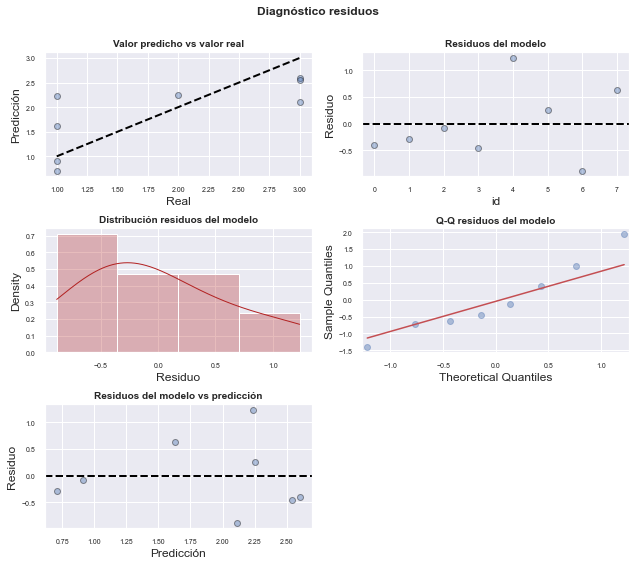


 Predicciones:
        mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
10  2.600341  0.380207       1.670008       3.530675      0.579914   
1   0.707874  0.517262      -0.557821       1.973570     -1.487255   
0   0.915314  0.450169      -0.186210       2.016839     -1.189433   
7   2.544536  0.364836       1.651814       3.437257      0.541149   

    obs_ci_upper  
10      4.620769  
1       2.903003  
0       3.020062  
7       4.547922  

El error (rmse) de test es: 0.7461188051215872



**********************************************************************************************************************
**********************************************************************************************************************
Lugar: Filtrado 17 - Turno F17 - Lote 1713
Plaga:  LEPIDOPTEROS (OTROS)
Caracteristica:  N° HOJAS INFESTADAS
Número de datos:  11
Variables X: ['TMP_PROM']



                            OLS Regression Results                            
Dep. Variab

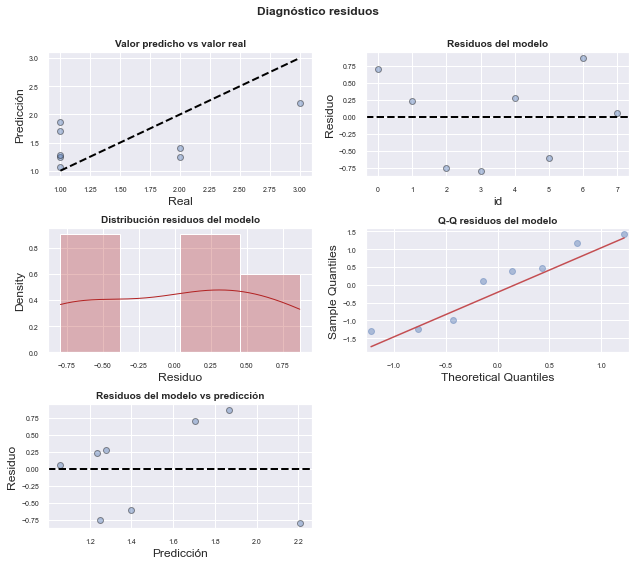


 Predicciones:
        mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
10  1.704673  0.283757       1.010346       2.399001     -0.142969   
1   1.234691  0.306032       0.485858       1.983523     -0.634118   
0   1.249202  0.300338       0.514302       1.984102     -0.614067   
7   2.206936  0.539997       0.885610       3.528262      0.044161   

    obs_ci_upper  
10      3.552316  
1       3.103499  
0       3.112471  
7       4.369711  

El error (rmse) de test es: 0.818696606812994



**********************************************************************************************************************
**********************************************************************************************************************
Lugar: Filtrado 20 - Turno F20 - Lote 2022
Plaga:  SABULODES AEGROTATA
Caracteristica:  N° HOJAS INFESTADAS
Número de datos:  11
Variables X: ['HM_PROM']



                            OLS Regression Results                            
Dep. Variable:

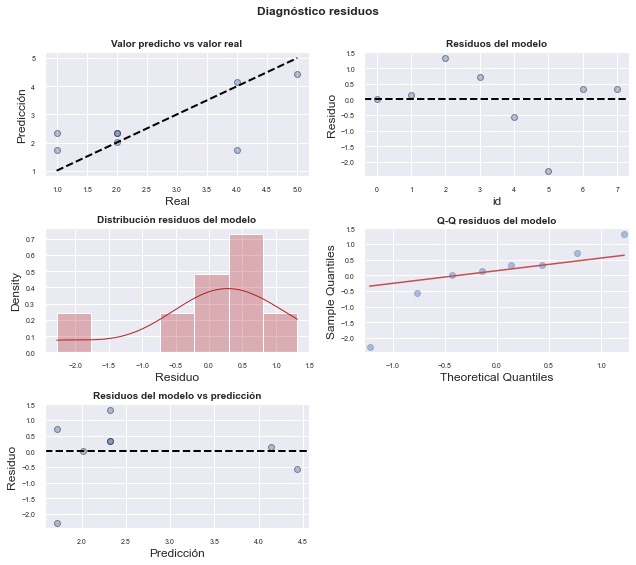


 Predicciones:
        mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
10  2.020349  0.478641       0.849155       3.191542     -1.040594   
1   4.136628  0.745165       2.313275       5.959980      0.771767   
0   2.322674  0.427202       1.277349       3.368000     -0.692351   
7   1.718023  0.553857       0.362783       3.073263     -1.417953   

    obs_ci_upper  
10      5.081291  
1       7.501489  
0       5.337700  
7       4.854000  

El error (rmse) de test es: 1.0231507059300937



**********************************************************************************************************************


In [23]:
arrPlagas = []
dfFilter = dfFilEleg
arrFiltrados = dfFilEleg['Filtrado'].unique()
#dfFilter = df
dfCorrexLote = pd.DataFrame(columns=['Filtrado', 'Turno', 'Lote', 'Plaga','Caracteristica'])
iContador = 0
for filtrado in arrFiltrados:
    dfFiltrado = dfFilter[dfFilter['Filtrado'] == filtrado]
    arrTurno = dfFiltrado['Turno'].unique()
    for turno in arrTurno:
        dfTurno = dfFiltrado[dfFiltrado['Turno'] == turno]
        arrLote = dfTurno['Lote'].unique()
        for lote in arrLote:  
            dfLote = dfTurno[dfTurno['Lote'] == lote]
            arrPlagaxLote = dfLote['Plaga'].unique()
            for plaga in arrPlagaxLote:
                dfPlaga = dfLote[dfLote['Plaga'] == plaga]
                arrPlagaxCarac = dfPlaga['Caracteristica'].unique()
                for caracteristica in arrPlagaxCarac:
                    dfCarac = dfPlaga[dfPlaga['Caracteristica'] == caracteristica]
                    dfCarac = dfCarac.sort_values(by=['Fecha'])
         
                    dfCarac = dfCarac.groupby(['Fecha','Fundo','Filtrado','Turno','Plaga','Caracteristica'])['Porcentaje'].sum().reset_index()
                    
                    fl_df_weather = df_weather[df_weather['Fecha'].isin(dfCarac['Fecha'])]
                    fl_df_weather = fl_df_weather.sort_values(by=['Fecha'])
                    fl_df_weather.reset_index(drop = True, inplace = True)
                    fl_df_weather = fl_df_weather.rename(columns = {'Fecha' : 'FechaClima'})
                    df_union = fl_df_weather.join(dfCarac)
                 
                    df_union = df_union[['Fecha','ET','TMP_PROM','RS_PROM','HM_PROM','Porcentaje']]        
                                   
                    df_union[["Porcentaje"]] = df_union[["Porcentaje"]].apply(pd.to_numeric)
                
                    dfCorrelacion = df_union.corr().abs()
                    
                    
                    dfCorrelacion_index = dfCorrelacion[dfCorrelacion['Porcentaje'] > 0.70]                
                    
                    if dfCorrelacion_index.shape[0] > 1 and df_union.shape[0] > 10:   
                        
                        arrColumns = dfCorrelacion_index.columns
                        arrColumnsUnion = []
                        ###########################################
                        for column in arrColumns:
                            if (dfCorrelacion_index[column]['Porcentaje'] > 0.70) & (column != 'Porcentaje'):
                                    arrColumnsUnion.append(column)
                        ############################################  
                        
                         #Creando regresión lineal
                        df_union = df_union.drop('Fecha' ,axis=1)
                        df_union = df_union.fillna(df_union.mean())
                       
                      
                        if df_union[arrColumnsUnion].shape[0] > 1:   
                            print('**********************************************************************************************************************')
                            # División de los datos en train y test
                            # ==============================================================================
                            print('Lugar: Filtrado {} - Turno {} - Lote {}'.format(filtrado,turno, lote))
                            print('Plaga: ', plaga)
                            print('Caracteristica: ', caracteristica)
                            print('Número de datos: ',  df_union[arrColumnsUnion].shape[0])
                            print('Variables X:', arrColumnsUnion)
                            print("\n"*2)
                            
                            X = df_union[arrColumnsUnion]
                            y = df_union['Porcentaje']

                            X_train, X_test, y_train, y_test = train_test_split(
                                                                    X,
                                                                    y.values.reshape(-1,1),
                                                                    train_size   = 0.8,
                                                                    random_state = 1234,
                                                                    shuffle      = True
                                                                )
                            # Creación del modelo utilizando matrices como en scikitlearn
                            # ==============================================================================
                            # A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
                            X_train = sm.add_constant(X_train, prepend=True)
                            modelo = sm.OLS(endog=y_train, exog=X_train,)
                            modelo = modelo.fit()
                            print(modelo.summary())
                            
                            print('\n Coeficientes')
                            print(modelo.params)
                            
                            # Intervalos de confianza para los coeficientes del modelo
                            # ==============================================================================
                            intervalos_ci = modelo.conf_int(alpha=0.05)
                            intervalos_ci.columns = ['2.5%', '97.5%']
                            
                            print('\nIntervalos de confianza: ')
                            print(intervalos_ci)
                            
                            
                            print('\n Diagnostico de residuos:')
                            # Diagnóstico errores (residuos) de las predicciones de entrenamiento
                            # ==============================================================================
                            y_train = y_train.flatten()
                            prediccion_train = modelo.predict(exog = X_train)
                            residuos_train   = prediccion_train - y_train
                            
                            # Gráficos
                            # ==============================================================================
                            fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 8))

                            axes[0, 0].scatter(y_train, prediccion_train, edgecolors=(0, 0, 0), alpha = 0.4)
                            axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                                            'k--', color = 'black', lw=2)
                            axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
                            axes[0, 0].set_xlabel('Real')
                            axes[0, 0].set_ylabel('Predicción')
                            axes[0, 0].tick_params(labelsize = 7)

                            axes[0, 1].scatter(list(range(len(y_train))), residuos_train,
                                               edgecolors=(0, 0, 0), alpha = 0.4)
                            axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
                            axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
                            axes[0, 1].set_xlabel('id')
                            axes[0, 1].set_ylabel('Residuo')
                            axes[0, 1].tick_params(labelsize = 7)

                            sns.histplot(
                                data    = residuos_train,
                                stat    = "density",
                                kde     = True,
                                line_kws= {'linewidth': 1},
                                color   = "firebrick",
                                alpha   = 0.3,
                                ax      = axes[1, 0]
                            )

                            axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                                                 fontweight = "bold")
                            axes[1, 0].set_xlabel("Residuo")
                            axes[1, 0].tick_params(labelsize = 7)


                            sm.qqplot(
                                residuos_train,
                                fit   = True,
                                line  = 'q',
                                ax    = axes[1, 1], 
                                color = 'firebrick',
                                alpha = 0.4,
                                lw    = 2
                            )
                            axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
                            axes[1, 1].tick_params(labelsize = 7)

                            axes[2, 0].scatter(prediccion_train, residuos_train,
                                               edgecolors=(0, 0, 0), alpha = 0.4)
                            axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
                            axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
                            axes[2, 0].set_xlabel('Predicción')
                            axes[2, 0].set_ylabel('Residuo')
                            axes[2, 0].tick_params(labelsize = 7)

                            # Se eliminan los axes vacíos
                            fig.delaxes(axes[2,1])

                            fig.tight_layout()
                            plt.subplots_adjust(top=0.9)
                            fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");
                            plt.show()
                            
                            # Predicciones con intervalo de confianza 
                            # ==============================================================================
                            predicciones = modelo.get_prediction(exog = X_train).summary_frame(alpha=0.05)
                            print('\n Predicciones:')
                            print(predicciones.head(4))
                            
                            # Error de test del modelo 
                            # ==============================================================================
                            X_test = sm.add_constant(X_test, prepend=True)
                            predicciones = modelo.predict(exog = X_test)
                            rmse = mean_squared_error(
                                    y_true  = y_test,
                                    y_pred  = predicciones,
                                    squared = False
                                   )
                            print("")
                            print(f"El error (rmse) de test es: {rmse}")
                            
                            print("\n"*2)
                            print('**********************************************************************************************************************')
                            

In [ ]:
#Filtrado 17 - Turno F17 - Lote 1701


In [ ]:
#Filtrado 20 - Turno F20 - Lote 2019

In [ ]:
#Filtrado 20 - Turno F20 - Lote 2020